# Segmentation

In [1]:
import sys
import time
import os
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import backend as K
import sklearn
from tensorflow.keras.models import Model
import tensorflow.keras
from sklearn.model_selection import KFold
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Input, UpSampling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential 
from tensorflow.keras import optimizers 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard

from IPython.display import SVG
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
import cv2

from tensorflow.keras.utils import plot_model

tf.__version__


OSError: libhsa-runtime64.so.1: cannot open shared object file: No such file or directory

In [29]:
WORKSPACE_BASE_PATH = "/mnt/sdb1/home/zeege/remote/bs/"
DATA_BASE_PATH = "/mnt/sdb1/home/zeege/remote/bs/data/segmentation/"
DATA_ORI_PATH = os.path.join(DATA_BASE_PATH, "origin")
DATA_GT_PATH = os.path.join(DATA_BASE_PATH, "groundtruth")
DATA_PRED_PATH = os.path.join(WORKSPACE_BASE_PATH, "pred")
DATA_PRED_BIN_PATH = os.path.join(WORKSPACE_BASE_PATH, "pred_bin")
TRAINING_LOG_PATH = os.path.join(WORKSPACE_BASE_PATH, "training_logs")
TRAINING_CHECKPOINT_PATH = os.path.join(WORKSPACE_BASE_PATH, "model_checkpoints")
TRAINING_TENSORBOARD_PATH = os.path.join(WORKSPACE_BASE_PATH, "tensorboard_logs")
sys.path.append(WORKSPACE_BASE_PATH)
def mymkdir(path):
    if not os.path.exists(path):
        os.mkdir(path)
    else:
        print(f"Found path [{path}]")
mymkdir(DATA_PRED_PATH)
mymkdir(DATA_PRED_BIN_PATH)
mymkdir(TRAINING_LOG_PATH)
mymkdir(TRAINING_CHECKPOINT_PATH)
mymkdir(TRAINING_TENSORBOARD_PATH)

Found path [/kaggle/working/training_logs]
Found path [/kaggle/working/model_checkpoints]
Found path [/kaggle/working/tensorboard_logs]


# Generator

In [47]:
def get_filepath_and_groundtruth(dataset_path, groundtruth_path) -> pd.DataFrame:
    datas = [os.path.join(dataset_path, i) for i in sorted(os.listdir(dataset_path))]
    gts = [os.path.join(groundtruth_path, i) for i in sorted(os.listdir(groundtruth_path))]
    df = pd.DataFrame([[d, g] for d, g in  zip(datas, gts)], columns=['origin', 'groundtruth'])
    return df

In [33]:
def build_train_generator(dataframe, origin_dir, mask_dir, target_size, enable_augment, 
                    origin_save_dir=None, mask_save_dir=None, batch_size=32, seed=42):
    if not enable_augment:
        ori_datagen = ImageDataGenerator(rescale=1./255)
        gt_datagen = ImageDataGenerator(rescale=1./255)
    else:
        datagen_args = dict(rescale=1./255,
                            rotation_range=89,
                            shear_range=0.5,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='reflect')
        ori_datagen = ImageDataGenerator(**datagen_args)
        gt_datagen = ImageDataGenerator(**datagen_args)

    flow_args = lambda col: dict(
        dataframe=dataframe,
        directory=origin_dir if col == 0 else mask_dir,
        x_col=dataframe.columns[col],
        class_mode=None,
        target_size=target_size,
        color_mode='grayscale',
        batch_size=batch_size,
        save_to_dir=origin_save_dir if col == 0 else mask_save_dir,
        seed=seed
    )
    ori_flow = ori_datagen.flow_from_dataframe(**flow_args(0))
    gt_flow = gt_datagen.flow_from_dataframe(**flow_args(1))
    
    for (img, mask) in zip(ori_flow, gt_flow):
        yield (img, mask)
        

def build_test_generator(dataframe, origin_dir, mask_dir, target_size, batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)
    flow_args = lambda col: dict(
        dataframe=dataframe,
        directory=origin_dir if col == 0 else mask_dir,
        x_col=dataframe.columns[col],
        class_mode=None,
        target_size=target_size,
        color_mode='grayscale',
        batch_size=batch_size,
        shuffle=False,
    )
    ori_flow = datagen.flow_from_dataframe(**flow_args(0))
    mask_flow = datagen.flow_from_dataframe(**flow_args(1))
    return ori_flow, mask_flow

# Loss

In [79]:
def dice_coef(y_true, y_pred):
    smooth = 1.0  # 0.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def jacard(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f + y_pred_f - y_true_f * y_pred_f)

    return intersection / union


def generalized_dice_coeff(y_true, y_pred):
    Ncl = y_pred.shape[-1]
    w = K.zeros(shape=(Ncl,))
    w = K.sum(y_true, axis=(0, 1, 2))
    w = 1 / (w ** 2 + 0.000001)
    # Compute gen dice coef:
    numerator = y_true * y_pred
    numerator = w * K.sum(numerator, (0, 1, 2, 3))
    numerator = K.sum(numerator)
    denominator = y_true + y_pred
    denominator = w * K.sum(denominator, (0, 1, 2, 3))
    denominator = K.sum(denominator)
    gen_dice_coef = 2 * numerator / denominator
    return gen_dice_coef


def generalized_dice_loss(y_true, y_pred):
    return 1 - generalized_dice_coeff(y_true, y_pred)


# Model

In [9]:
def conv2d_bn(x, filters, ksize, d_rate, strides, padding='same', activation='relu', groups=1, name=None):
    '''
    2D Convolutional layers
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, kernel_size=ksize, strides=strides, padding=padding, dilation_rate=d_rate, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if (activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


In [10]:
def CFPModule(inp, filters, d_size):
    '''
    CFP module for medicine
    
    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''
    x_inp = conv2d_bn(inp, filters // 4, ksize=1, d_rate=1, strides=1)

    x_1_1 = conv2d_bn(x_inp, filters // 16, ksize=3, d_rate=1, strides=1, groups=filters // 16)
    x_1_2 = conv2d_bn(x_1_1, filters // 16, ksize=3, d_rate=1, strides=1, groups=filters // 16)
    x_1_3 = conv2d_bn(x_1_2, filters // 8, ksize=3, d_rate=1, strides=1, groups=filters // 8)

    x_2_1 = conv2d_bn(x_inp, filters // 16, ksize=3, d_rate=d_size // 4 + 1, strides=1, groups=filters // 16)
    x_2_2 = conv2d_bn(x_2_1, filters // 16, ksize=3, d_rate=d_size // 4 + 1, strides=1, groups=filters // 16)
    x_2_3 = conv2d_bn(x_2_2, filters // 8, ksize=3, d_rate=d_size // 4 + 1, strides=1, groups=filters // 8)

    x_3_1 = conv2d_bn(x_inp, filters // 16, ksize=3, d_rate=d_size // 2 + 1, strides=1, groups=filters // 16)
    x_3_2 = conv2d_bn(x_3_1, filters // 16, ksize=3, d_rate=d_size // 2 + 1, strides=1, groups=filters // 16)
    x_3_3 = conv2d_bn(x_3_2, filters // 8, ksize=3, d_rate=d_size // 2 + 1, strides=1, groups=filters // 8)

    x_4_1 = conv2d_bn(x_inp, filters // 16, ksize=3, d_rate=d_size + 1, strides=1, groups=filters // 16)
    x_4_2 = conv2d_bn(x_4_1, filters // 16, ksize=3, d_rate=d_size + 1, strides=1, groups=filters // 16)
    x_4_3 = conv2d_bn(x_4_2, filters // 8, ksize=3, d_rate=d_size + 1, strides=1, groups=filters // 8)

    o_1 = layers.concatenate([x_1_1, x_1_2, x_1_3], axis=3)
    o_2 = layers.concatenate([x_2_1, x_2_2, x_2_3], axis=3)
    o_3 = layers.concatenate([x_1_1, x_3_2, x_3_3], axis=3)
    o_4 = layers.concatenate([x_1_1, x_4_2, x_4_3], axis=3)

    o_1 = BatchNormalization(axis=3)(o_1)
    o_2 = BatchNormalization(axis=3)(o_2)
    o_3 = BatchNormalization(axis=3)(o_3)
    o_4 = BatchNormalization(axis=3)(o_4)

    ad1 = o_1
    ad2 = layers.add([ad1, o_2])
    ad3 = layers.add([ad2, o_3])
    ad4 = layers.add([ad3, o_4])
    output = layers.concatenate([ad1, ad2, ad3, ad4], axis=3)
    output = BatchNormalization(axis=3)(output)
    output = conv2d_bn(output, filters, ksize=1, d_rate=1, strides=1, padding='valid')
    output = layers.add([output, inp])

    return output

In [11]:
def CFPNetM(input_shape):
    inputs = Input(shape=input_shape)

    conv1 = conv2d_bn(inputs, 32, 3, 1, 2)
    conv2 = conv2d_bn(conv1, 32, 3, 1, 1)
    conv3 = conv2d_bn(conv2, 32, 3, 1, 1)
    injection_1 = AveragePooling2D()(inputs)
    injection_1 = BatchNormalization(axis=3)(injection_1)
    injection_1 = Activation('relu')(injection_1)
    opt_cat_1 = layers.concatenate([conv3, injection_1], axis=3)

    # CFP block 1
    opt_cat_1_0 = conv2d_bn(opt_cat_1, 64, 3, 1, 2)
    cfp_1 = CFPModule(opt_cat_1_0, 64, 2)
    cfp_2 = CFPModule(cfp_1, 64, 2)

    injection_2 = AveragePooling2D()(injection_1)
    injection_2 = BatchNormalization(axis=3)(injection_2)
    injection_2 = Activation('relu')(injection_2)
    opt_cat_2 = layers.concatenate([cfp_2, opt_cat_1_0, injection_2], axis=3)

    # CFP block 2
    opt_cat_2_0 = conv2d_bn(opt_cat_2, 128, 3, 1, 2)
    cfp_3 = CFPModule(opt_cat_2_0, 128, 4)
    cfp_4 = CFPModule(cfp_3, 128, 4)
    cfp_5 = CFPModule(cfp_4, 128, 8)
    cfp_6 = CFPModule(cfp_5, 128, 8)
    cfp_7 = CFPModule(cfp_6, 128, 16)
    cfp_8 = CFPModule(cfp_7, 128, 16)

    injection_3 = AveragePooling2D()(injection_2)
    injection_3 = BatchNormalization(axis=3)(injection_3)
    injection_3 = Activation('relu')(injection_3)
    opt_cat_3 = layers.concatenate([cfp_8, opt_cat_2_0, injection_3], axis=3)

    conv4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', activation='relu')(opt_cat_3)
    up_1 = layers.concatenate([conv4, opt_cat_2])
    conv5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(up_1)
    up_2 = layers.concatenate([conv5, opt_cat_1], axis=3)
    conv6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(up_2)
    conv7 = conv2d_bn(conv6, 1, 1, 1, 1, activation='sigmoid', padding='valid')

    model = Model(inputs=inputs, outputs=conv7)

    return model


In [12]:
def Unet(input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = layers.concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = layers.concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model


# Training

In [22]:
def train_simplecnn(model,
                    *,
                    target_size,
                    n_split=5,
                    enable_kfold=False,
                    steps_per_epoch,
                    number_of_epochs, validation_steps,
                    origin_path, groundtruth_path, 
                    history_filepath, checkpoint_path, checkpoint_prefix, tensorboard_log_path, seed=42):
    dataframe = get_filepath_and_groundtruth(origin_path, groundtruth_path)
    histories = []
    models = []
    kf = KFold(n_splits=n_split, shuffle=True, random_state=seed)
    fold_cnt = 0
    for train_index, test_index in kf.split(dataframe):
        # data preparation
        fold_cnt += 1
        train_data = dataframe.iloc[train_index]
        test_data = dataframe.iloc[test_index]
        print(f"Start KFold {fold_cnt}/{n_split}\n")
        train_generator = build_train_generator(train_data, origin_path, groundtruth_path, target_size, True, seed=seed)
        validation_generator = build_train_generator(test_data, origin_path, groundtruth_path, target_size, False, seed=seed)

        # initialize loggers
        csv_logger = CSVLogger(filename=history_filepath)
        check_pointer = ModelCheckpoint(
            checkpoint_path +
            '%s_weights.{epoch:02d}-{val_loss:.2f}.hdf5' % checkpoint_prefix,
            monitor='val_loss',
            mode='auto',
            save_best_only=True
        )
        tensorboard_logger = TensorBoard(
            log_dir=tensorboard_log_path, histogram_freq=0,
            write_graph=True, write_images=True
        )
        tensorboard_logger.set_model(model)

        # start training
        history = model.fit(
            train_generator,
            epochs=number_of_epochs,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            validation_data=validation_generator,
            callbacks=[check_pointer, csv_logger, tensorboard_logger, lr_scheduler, lr_reducer]
        )
        models.append(model)
        histories.append(history)
        if not enable_kfold:
            break
    return histories, models


In [14]:
def schedule_lr(epoch):
    lr = 1e-3
    if epoch > 80:
        lr = 1e-6
    elif epoch > 60:
        lr = 5e-6
    elif epoch > 40:
        lr = 1e-5
    elif epoch > 20:
        lr = 5e-5
    print(f"Learning rate: {lr}")
    return lr


lr_scheduler = LearningRateScheduler(schedule_lr)

lr_reducer = ReduceLROnPlateau(factor=0.2,
                               cooldown=0,
                               patience=3,
                               min_lr=1e-6)

In [71]:
INPUT_SHAPE = (256, 256)
model = CFPNetM((*INPUT_SHAPE, 1))
model.compile(loss=generalized_dice_loss,
              optimizer=optimizers.Adam(schedule_lr(0)),
              metrics=[jacard, dice_coef, 'accuracy'])
model.run_eagerly = True
model.summary()

Learning rate: 0.001
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_708 (Conv2D)             (None, 128, 128, 32) 288         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_966 (BatchN (None, 128, 128, 32) 96          conv2d_708[0][0]                 
__________________________________________________________________________________________________
activation_726 (Activation)     (None, 128, 128, 32) 0           batch_normalization_966[0][0]    
_______________________________________________________________________

In [80]:
MODEL_NAME = "segmentation_" + time.strftime("%m%d_%H%M", time.localtime())
if not os.path.exists(os.path.join(WORKSPACE_BASE_PATH, "training_logs")):
    os.mkdir(os.path.join(WORKSPACE_BASE_PATH, "training_logs"))
model.run_eagerly = True
histories, mods = train_simplecnn(model,
                target_size=INPUT_SHAPE,
                origin_path=DATA_ORI_PATH,
                groundtruth_path=DATA_GT_PATH,
                number_of_epochs=100,
                steps_per_epoch=15,
                validation_steps=1,
                enable_kfold=False,
                history_filepath=WORKSPACE_BASE_PATH+"training_logs/"+MODEL_NAME+".csv",
                checkpoint_prefix=MODEL_NAME,
                checkpoint_path=WORKSPACE_BASE_PATH+"model_checkpoints/",
                tensorboard_log_path=WORKSPACE_BASE_PATH+"tensorboard_logs/",
)

Start KFold 1/5

Found 30 validated image filenames.
Found 30 validated image filenames.
Epoch 1/100
Learning rate: 0.001
15/15 [==============================] - ETA: 0s - loss: 0.3123 - jacard: 0.5242 - dice_coef: 0.6877 - accuracy: 0.7541Found 8 validated image filenames.
Found 8 validated image filenames.
15/15 [==============================] - 12s 822ms/step - loss: 0.3123 - jacard: 0.5242 - dice_coef: 0.6877 - accuracy: 0.7541 - val_loss: 0.4149 - val_jacard: 0.4136 - val_dice_coef: 0.5851 - val_accuracy: 0.6470
Epoch 2/100
Learning rate: 0.001
15/15 [==============================] - 12s 791ms/step - loss: 0.2814 - jacard: 0.5609 - dice_coef: 0.7186 - accuracy: 0.8588 - val_loss: 0.4209 - val_jacard: 0.4075 - val_dice_coef: 0.5791 - val_accuracy: 0.6541
Epoch 3/100
Learning rate: 0.001
15/15 [==============================] - 12s 818ms/step - loss: 0.2658 - jacard: 0.5800 - dice_coef: 0.7342 - accuracy: 0.9020 - val_loss: 0.3873 - val_jacard: 0.4417 - val_dice_coef: 0.6127 - va

# Evaluation

In [50]:
def load_model(filepath):
    print("Loading model...")
    model = models.load_model(
        filepath=filepath,
        custom_objects=dict(jacard=jacard, dice_coef=dice_coef,
                            generalized_dice_loss=generalized_dice_loss),
        compile=True, options=None
    )
    return model


def save_result(save_path, start_idx, npyfile):
    for i, item in enumerate(npyfile, start=start_idx):
        img = item[:, :, 0]
        io.imsave(os.path.join(save_path, f"{str(i).zfill(6)}_predict.png"), img)


def evaluate_model(pred_path, mask_path, input_shape):
    jcs = []
    dices = []
    accs = []
    df = get_filepath_and_groundtruth(pred_path, mask_path)
    pred_gen, truth_gen = build_test_generator(df, pred_path, mask_path, INPUT_SHAPE, 1)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    test_index = [i for i in kf.split(df).__next__()[1]]
    print("Test Index:", test_index)
    for i, preds, truths in zip(range(pred_gen.samples), pred_gen, truth_gen):
        pred = preds[0]
        truth = truths[0]
        jcs.append(jacard(truth, pred))
        dices.append(dice_coef(truth, pred))
        accs.append((pred == truth).sum() / (input_shape[0] * input_shape[1]))
    print("Average jacard: ", np.average(jcs))
    print("Average dice: ", np.average(dices))
    print("Average acc: ", np.average(accs))

    fig, axes = plt.subplots(1, 1, figsize=(20, 6))
    axes.set_xlim(-1, pred_gen.samples)
    axes.set_ylim(0.7, 1.01)
    axes.xaxis.set_major_locator(plt.MultipleLocator(1.0))
    axes.grid(which='major', axis="x", linewidth=0.75,
            linestyle='-', color='#dddddd')
    axes.set_xlabel("Images")
    axes.set_ylabel("Values")
    axes.set_title(f"Evaluation on size {INPUT_SHAPE[0]}*{INPUT_SHAPE[1]}")
    axes.scatter(np.arange(pred_gen.samples), jcs, marker='o')
    axes.scatter(np.arange(pred_gen.samples), dices, marker='D')
    axes.scatter(np.arange(pred_gen.samples), accs, marker='*')
    for i in test_index:
        axes.vlines(i, 0, 1.1, linewidth=1.25, color="#aaaaaa")
    axes.legend(["Jacard", "Dice", "Acc", "Test"])


def predict_model(model, origin_path, mask_path, save_path, save_bin_path, input_shape=(256, 256), batch_size=32):
    df = get_filepath_and_groundtruth(origin_path, mask_path)
    test_gen, mask_gen = build_test_generator(df, origin_path, mask_path, input_shape, batch_size)
    batches = (test_gen.samples + batch_size - 1) // batch_size
    print(f"Start predicting. {batches} * {batch_size} / batch")
    for i in range(batches):
        print(f"{i}, ", end="")
        gen = test_gen.__next__()
        results = model.predict(gen, steps=1, verbose=0)
        results_bin = np.round(results)
        save_result(save_path, i * batch_size, (results * 255).astype(np.uint8))
        save_result(save_bin_path, i * batch_size, (results_bin * 255).astype(np.uint8))
    print("\nEvaluating results...")
    evaluate_model(save_bin_path, mask_path, input_shape)

    
def plot_learning_curves_from_history_file(filename):
    history = pd.read_csv(filename)
    hv = history.values
    epoch = hv[:, 0]
    acc = hv[:, 1]
    dice_coef = hv[:, 2]
    jacard = hv[:, 3]
    loss = hv[:, 4]
    val_acc = hv[:, 5]
    val_dice_coef = hv[:, 6]
    val_jacard = hv[:, 7]
    val_loss = hv[:, 8]
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))

    axes[0, 0].plot(epoch, acc, epoch, val_acc, linewidth=1)
    axes[0, 0].set_title('Accuracy')
    axes[0, 0].grid(which="Both")
    axes[0, 0].set_ylabel('accuracy')
    axes[0, 0].set_xlabel('epoch')
    axes[0, 0].legend(['train', 'test'])

    axes[0, 1].plot(epoch, loss, epoch, val_loss, linewidth=1)
    axes[0, 1].set_title('Loss')
    axes[0, 1].grid(which="Both")
    axes[0, 1].set_ylabel('loss')
    axes[0, 1].set_xlabel('epoch')
    axes[0, 1].legend(['train', 'test'])

    axes[1, 0].plot(epoch, dice_coef, epoch, val_dice_coef, linewidth=1)
    axes[1, 0].set_title('Dice coef')
    axes[1, 0].grid(which="Both")
    axes[1, 0].set_ylabel('dice coef')
    axes[1, 0].set_xlabel('epoch')
    axes[1, 0].legend(['train', 'test'])

    axes[1, 1].plot(epoch, jacard, epoch, val_jacard, linewidth=1)
    axes[1, 1].set_title('Jacard')
    axes[1, 1].grid(which="Both")
    axes[1, 1].set_ylabel('jacard')
    axes[1, 1].set_xlabel('epoch')
    axes[1, 1].legend(['train', 'test'])
    return fig

/kaggle/working/model_checkpoints/segmentation_1225_0501_weights.48-0.23.hdf5
Loading model...
Found 38 validated image filenames.
Found 38 validated image filenames.
Start predicting. 10 * 4 / batch
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
Evaluating results...
Found 38 validated image filenames.
Found 38 validated image filenames.
Test Index: [4, 6, 13, 26, 27, 30, 33, 36]
Average jacard:  0.9280804
Average dice:  0.9619744
Average acc:  0.9531767995733964


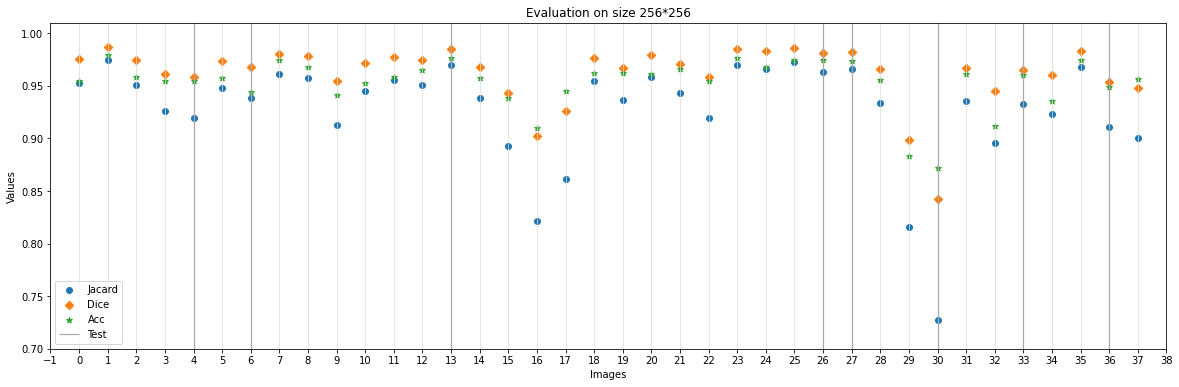

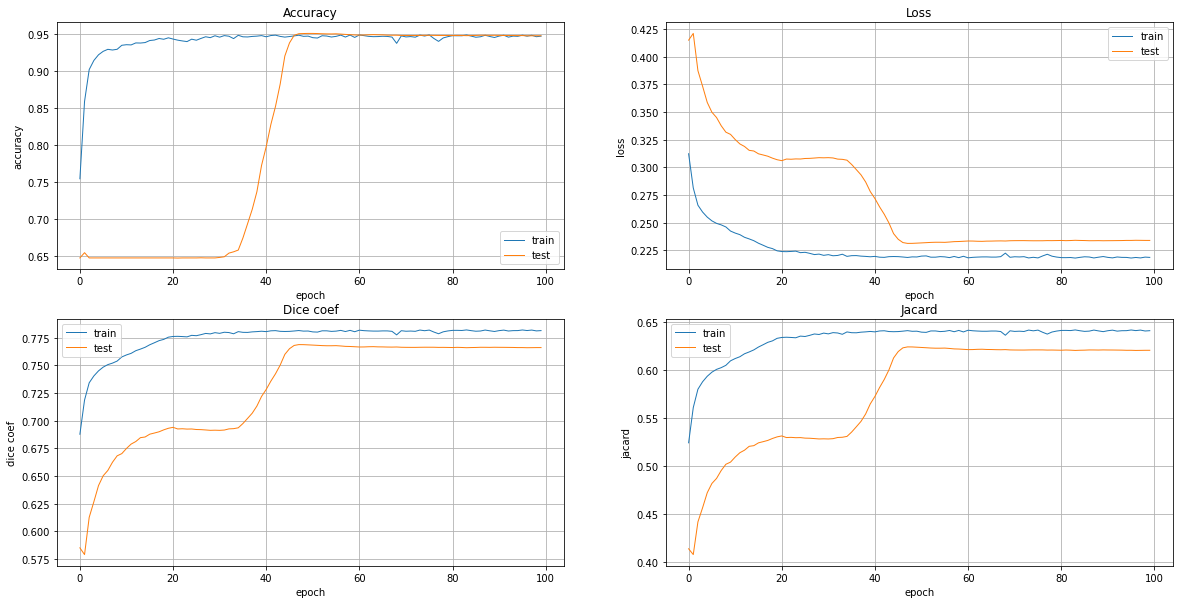

In [81]:
list_of_files = glob.glob(WORKSPACE_BASE_PATH+'model_checkpoints/*.hdf5')
CHECKPOINT_FILE = max(list_of_files, key=os.path.getctime)  # last checkpoint
VERSION = 1
print(CHECKPOINT_FILE)
model = load_model(CHECKPOINT_FILE)
predict_model(model, DATA_ORI_PATH, DATA_GT_PATH, DATA_PRED_PATH, DATA_PRED_BIN_PATH, INPUT_SHAPE, 4)
fig = plot_learning_curves_from_history_file(WORKSPACE_BASE_PATH+"/training_logs/"+MODEL_NAME+".csv")

# Playground

In [ ]:
def invert_color():
    for filename in os.listdir(os.path.join(DATA_BASE_PATH, "mask")):
        img = cv2.imread(f"{DATA_BASE_PATH}mask/{filename}", 1)
        print(f"{DATA_BASE_PATH}mask/{filename}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = 255 - img
        io.imsave(f"{DATA_BASE_PATH}mask_inv/{filename}", img)